# Model I: Support Vector Machine (SVM) + Zernike Moments (ZMs)

**Most of this code is made by the authors of the paper of Ghaderi et al. (2025) (https://iopscience.iop.org/article/10.3847/1538-4365/ada8ab) and taken from the GitHub Repository: https://github.com/hmddev1/machine_learning_for_morphological_galaxy_classification**

**This notebook classifies the images to galaxies and non-galaxies. Here we reproduce their results.**

This model uses **just** the Zernike Moments (ZMs) as the data to classify the galaxies. These are essentially features extracted from the images mathematically, so a CNN is not needed here, at least not in the traditional sense. The Zernike order used in this model is 45.

In [ ]:
import os
path = '/content/drive/Shared drives/DLP Project/Project/Models/Galaxy-Nongalaxy Models'
os.chdir(path)

In [ ]:
#!pip install opencv-python
#!pip install tensorflow

In [ ]:
%run imports.py
%matplotlib inline

In [ ]:
import plotting

Here, we create a dictionary where we will save the ROC curves of each model in order to plot them all together at the end to make comparisons.

In [ ]:
roc_curves = {}

## Loading the data and the labels

In [ ]:
# This cell takes a while
galaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/galaxy_zms.csv')
nongalaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/nongalaxy_zms.csv')

galaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)
nongalaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)

zmg = np.array(galaxy_zm)
zmng = np.array(nongalaxy_zm)

all_zm_data = np.concatenate([zmg,zmng])
len(zmg), len(zmng), len(all_zm_data)

(780, 555, 1335)

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

1335

## Splitting into train and test sets

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

## Training

The **SVM** model uses radial base kernel (rbf), C = 1.5, and gamma = 'scale' to fit the model on the training set:

In [ ]:
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

## Performance

Now, we apply the model to the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

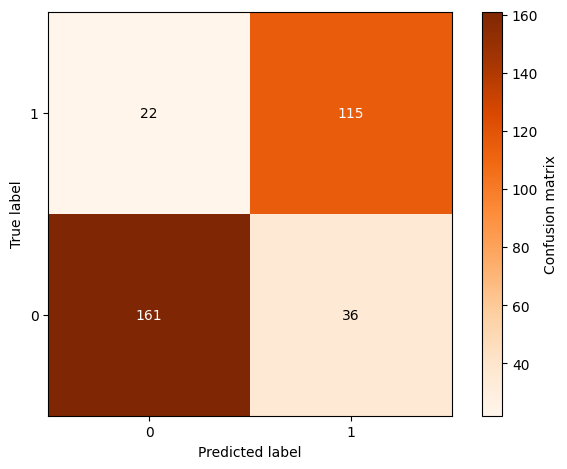

In [ ]:
# Confusion matrix
y_pred = model.predict(X_test)
plotting.plot_confusion_matrix(y_test, y_pred, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

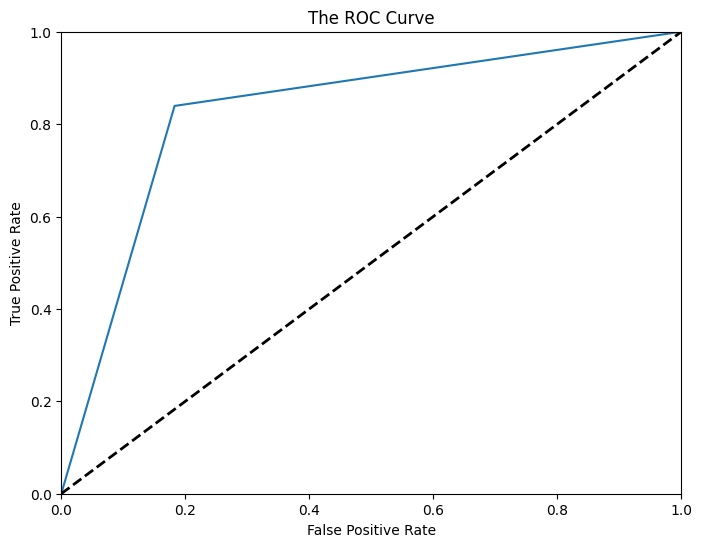

In [ ]:
# Save ROC curves to plot them all together later
model_i_roc_curves = []

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

# Save curves to list
model_i_roc_curves.append((fpr, tpr, auc))

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model I'] = model_i_roc_curves

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
recall = recall_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.8263473053892215
Precision: 0.8313014617816804
F1_score: 0.8273691651784152
Accuracy: 0.8263473053892215
TSS: 0.6566749416428915
AUC: 0.8283374708214457


# Model II: 1D Convolutional Neural Network (CNN) + Zernike Moments (ZMs)

## Splitting into train and test sets

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=2)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

## Training

Due to one dimentional structure of ZMs, we used one dimentional achitecture of CNN:

In [ ]:
def build_model():
  # input value
  x = Input(shape=(all_zm_data.shape[1],1))

  #hidden layers
  c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
  b0 = BatchNormalization()(c0)
  m0 = MaxPooling1D(pool_size=2)(b0)
  d0 = Dropout(0.1)(m0)

  c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
  b1 = BatchNormalization()(c1)
  m1 = MaxPooling1D(pool_size=2)(b1)
  d1 = Dropout(0.1)(m1)

  c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
  b2 = BatchNormalization()(c2)
  m2 = MaxPooling1D(pool_size=2)(b2)
  d2 = Dropout(0.1)(m2)

  f = Flatten()(d2)

  # output
  de0 = Dense(64, activation='relu')(f)
  de1 = Dense(32, activation='relu')(de0)
  de2 = Dense(2, activation='softmax')(de1)

  model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_nonegalaxy")

  return model

In [ ]:
model = build_model()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_zm_45_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,730 (772.38 KB)

 Trainable params: 196,834 (768.88 KB)

 Non-trainable params: 896 (3.50 KB)

The **1D CNN** model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Getting the initial weights of the model
# in case we need to reset it later - Issa
initial_weights = model.get_weights()

In [ ]:
# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Shuffle weights
for layer in model.layers:
    weights = layer.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    layer.set_weights(weights)

# Callback Function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 10

history = model.fit(
X_train, y_train_encoded,
batch_size=b_size,
epochs=e_num,
class_weight=class_weights,
verbose = 1,
callbacks=es,
validation_split=0.1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 765ms/step - accuracy: 0.7160 - loss: 0.6087 - val_accuracy: 0.6436 - val_loss: 1.7875
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 706ms/step - accuracy: 0.8011 - loss: 0.4326 - val_accuracy: 0.7624 - val_loss: 0.8114
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - accuracy: 0.7309 - loss: 0.4655 - val_accuracy: 0.7723 - val_loss: 0.8166
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - accuracy: 0.7979 - loss: 0.4439 - val_accuracy: 0.8119 - val_loss: 0.5835
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.8184 - loss: 0.4265 - val_accuracy: 0.8317 - val_loss: 0.4560
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - accuracy: 0.8530 - loss: 0.3484 - val_accuracy: 0.7624 - val_loss: 0.4836
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 658ms/step - accuracy: 0.8618 - loss: 0.3227 - val_accuracy: 0.7921 - val_loss: 0.4605
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - accuracy: 0.8468 - loss: 0.3297 - val_accu

## Performance

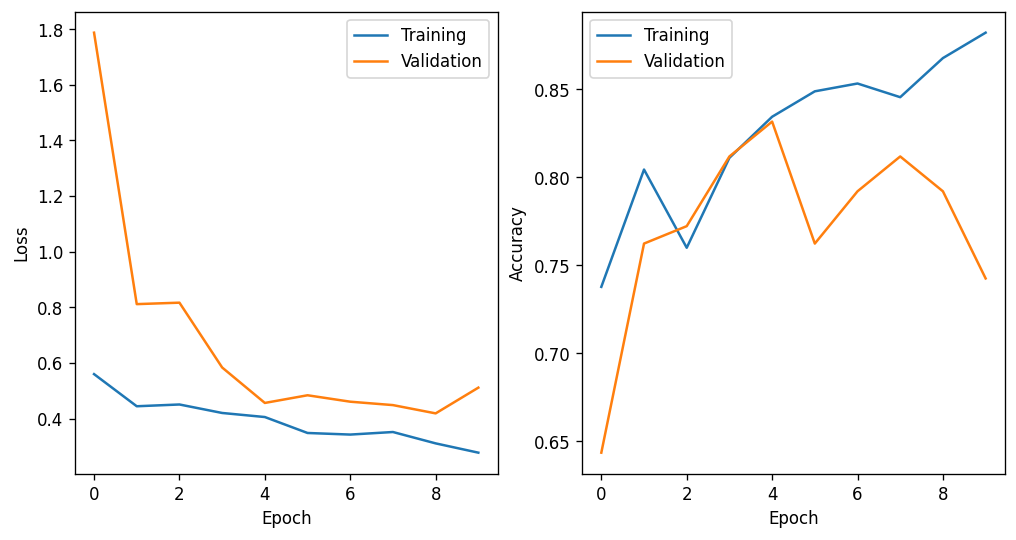

In [ ]:
plotting.plot_model_history(history, dpi=120)

Now, we apply the model to the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


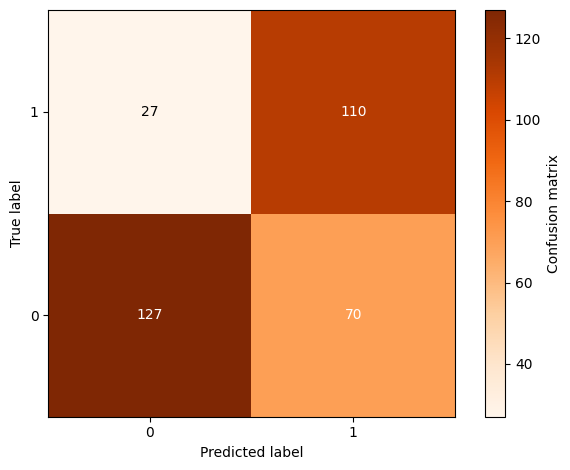

In [ ]:
# Confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
plotting.plot_confusion_matrix(y_test, y_pred_labels, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

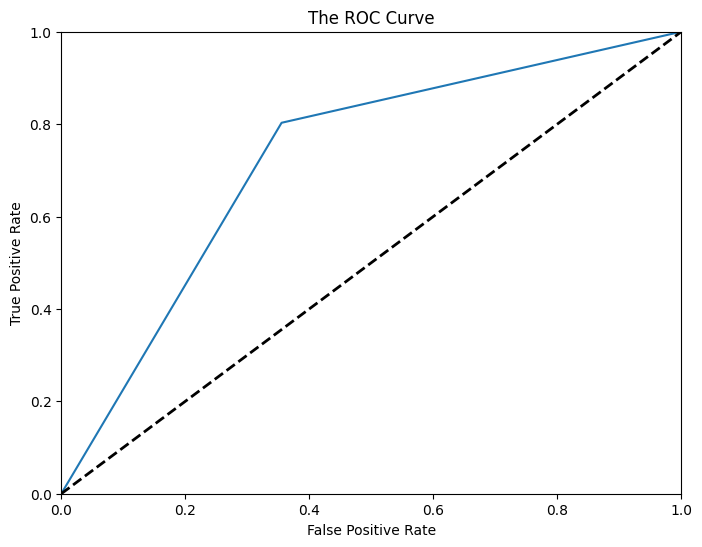

In [ ]:
# Save ROC curves to plot them all together later
model_ii_roc_curves = []

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

# Save curves to list
model_ii_roc_curves.append((fpr, tpr, auc))

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model II'] = model_ii_roc_curves

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
#Madalena: This cell doesn't work because the authors used y_pred instead of y_pred_labels. In addition, they redefine f1_score which causes problems later.
# recall = recall_score(y_test, y_pred, average= 'weighted')
# precision = precision_score(y_test, y_pred, average= 'weighted')
# f1_score = f1_score(y_test, y_pred, average= 'weighted')
# accuracy = accuracy_score(y_test, y_pred)

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
#fix made by Madalena
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
#print("F1_score:", f1_score)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.7095808383233533
Precision: 0.7370756322852131
F1_score: 0.7114888290769966
Accuracy: 0.7095808383233533
TSS: 0.4475897587906184
AUC: 0.7237948793953093


# Model III: 2D Convolutional Neural Network (CNN) with Vision Transformer (ViT) and original images

This model uses the original images as inputs to a CNN with a Vision Transformer (ViT) to classify the galaxies. ViT is used as a data augmentation tool on the Galaxy and Non-Galaxy images. The Zernike Moments (ZMs) are not used here.

## Loading the data (images)
To read the images of each class and convert to Pillow images we used the following function (Ghaderi et al., 2024):

In [ ]:
def load_images(data_dir, target_size):

        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in file_path:
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

In [ ]:
# This cell takes a while.

# Also need to modify the path so that it's accesible to Jelle and Sasha.
# We can do this at the end, but let's try not to forget about it. - Issa

nongalaxy_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/nongalaxy'
galaxy_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/galaxy'

image_size = 200

g_img = load_images(galaxy_path, target_size=(image_size,image_size))
ng_img = load_images(nongalaxy_path, target_size=(image_size,image_size))

all_data = g_img + ng_img
np.shape(all_data)

(1335, 200, 200, 3)

## Vision Transformer

We define the vision transformer for both training and testing data sets:

In [ ]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

## Splitting into train and test sets

We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=2)

## Applying the Vision Transformer (ViT)

We apply the vision transformer to both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

## Training

The structure of the classic CNN model:

In [ ]:
def build_model():
  # input
  x = Input(shape=(image_size,image_size,3))

  #hidden layers
  c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
  b0 = BatchNormalization()(c0)
  m0 = MaxPooling2D(pool_size=(2, 2))(b0)
  d0 = Dropout(0.1)(m0)

  c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
  b1 = BatchNormalization()(c1)
  m1 = MaxPooling2D(pool_size=(2, 2))(b1)
  d1 = Dropout(0.1)(m1)

  c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
  b2 = BatchNormalization()(c2)
  m2 = MaxPooling2D(pool_size=(2, 2))(b2)
  d2 = Dropout(0.1)(m2)

  f = Flatten()(m2)

  # output layers
  de0 = Dense(64, activation='relu')(f)
  de1 = Dense(32, activation='relu')(de0)
  de2 = Dense(2, activation='softmax')(de1)

  model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")

  return model

In [ ]:
model = build_model()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_transformer_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 200, 200, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940,002 (11.22 MB)

 Trainable params: 2,939,106 (11.21 MB)

 Non-trainable params: 896 (3.50 KB)

The CNN model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Getting the initial weights of the model
# in case we need to reset it later - Issa
initial_weights = model.get_weights()

In [ ]:
# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Shuffle weights
for layer in model.layers:
    weights = layer.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    layer.set_weights(weights)

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1
)

## Performance

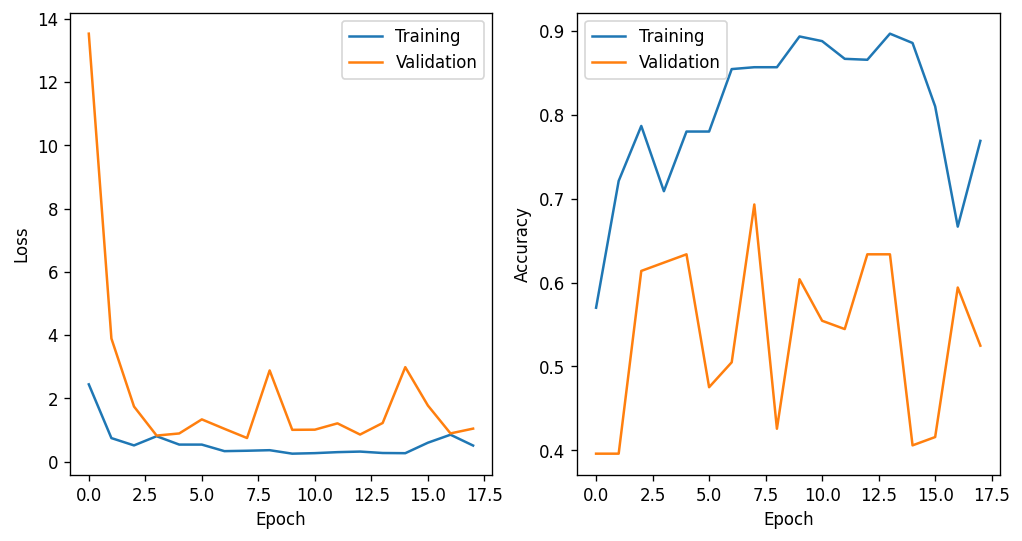

In [ ]:
plotting.plot_model_history(history, dpi=120)

Now, we apply the model to the test set to examine the classification algorithm. Using the label predicted by the machine on original labels, we compute the elements of the confusion matrix.

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step


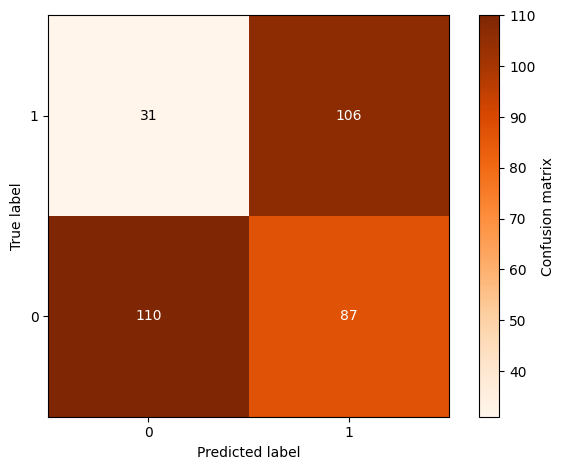

In [ ]:
# Confusion matrix
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)
plotting.plot_confusion_matrix(y_test, y_pred_labels, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

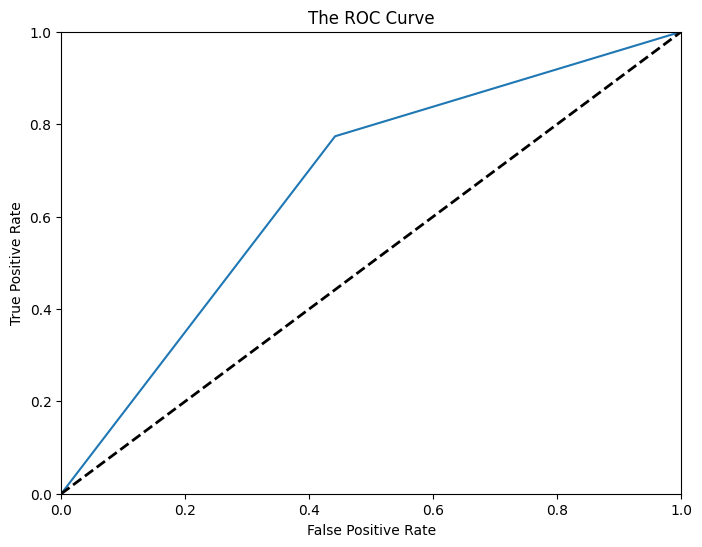

In [ ]:
# Save ROC curves to plot them all together later
model_iii_roc_curves = []

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

# Save curves to list
model_iii_roc_curves.append((fpr, tpr, auc))

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model III'] = model_iii_roc_curves

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
# #Madalena: This cell doesn't work because the authors used y_pred instead of y_pred_labels.
# In addition, they redefine f1_score which causes problems later.

# recall = recall_score(y_test, y_pred, average= 'weighted')
# precision = precision_score(y_test, y_pred, average= 'weighted')
# f1_score = f1_score(y_test, y_pred, average= 'weighted')
# accuracy = accuracy_score(y_test, y_pred)

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
#fix made by Madalena
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.6467065868263473
Precision: 0.6854235526301603
F1_score: 0.6474160876740334
Accuracy: 0.6467065868263473
TSS: 0.33209826225499284
AUC: 0.6660491311274965


# Model IV: ResNet50 Convolutional Neural Network (CNN) with Vision Transformer (ViT) and original images

This model uses the original images as inputs to a CNN with a Vision Transformer (ViT) to classify the galaxies. ViT is used as a data augmentation tool on the Galaxy and Non-Galaxy images. The Zernike Moments (ZMs) are not used here.

## Vision Transformer

We define the vision transformer for both training and testing data sets:

## Splitting into train and test sets

We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=2)

## Applying the Vision Transformer (ViT)

We apply the vision transformer to both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

## Training

The structure of the classic CNN model:

In [ ]:
def build_model():
  # Defining the pretrained ResNet50
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

  x = Flatten()(base_model.output)
  x = Dense(64, activation='relu')(x)  # The custom layers
  output = Dense(2, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)

  return model

ResNet50 uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Getting the initial weights of the model
# in case we need to reset it later - Issa
initial_weights = model.get_weights()

In [ ]:
# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6721 - loss: 2.9133 - val_accuracy: 0.3960 - val_loss: 184851488.0000
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.8279 - loss: 0.3915 - val_accuracy: 0.3960 - val_loss: 1626371.6250
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.7879 - loss: 6.9458 - val_accuracy: 0.6040 - val_loss: 116584.4219
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - accuracy: 0.7851 - loss: 0.4651 - val_accuracy: 0.6040 - val_loss: 46392.3945
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - accuracy: 0.7920 - loss: 0.5459 - val_accuracy: 0.3960 - val_loss: 74133.0938
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.7721 - loss: 0.4653 - val_accuracy: 0.3960 - val_loss: 30346.6934
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - accuracy: 0.8391 - loss: 0.3946 - val_accuracy: 0.3960 - val_loss: 9570.7822
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.8

## Performance

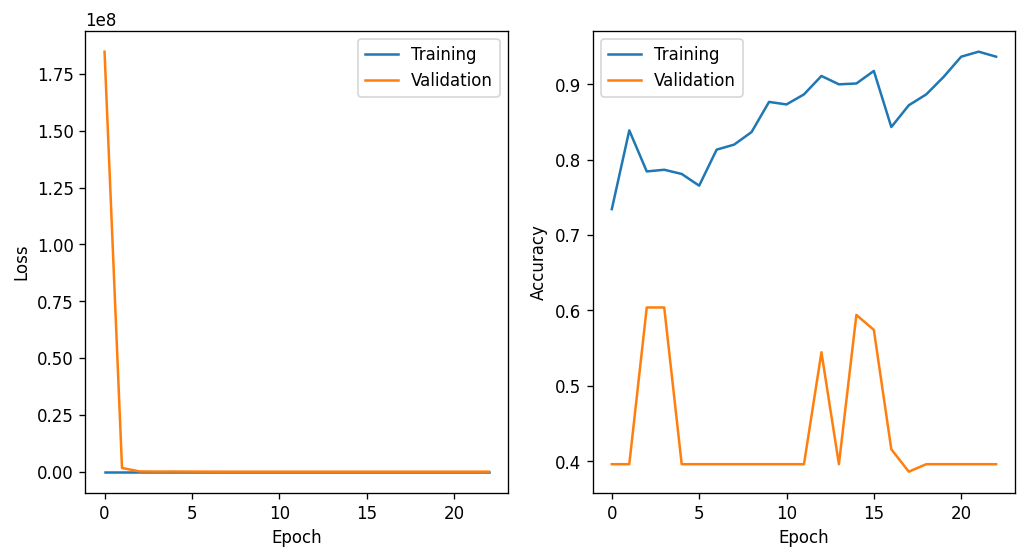

In [ ]:
plotting.plot_model_history(history, dpi=120)

Now, we apply the model to the test set to examine the classification algorithm. Using the label predicted by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
# Confusion matrix
X_test = np.array(transformed_X_test)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 605ms/step


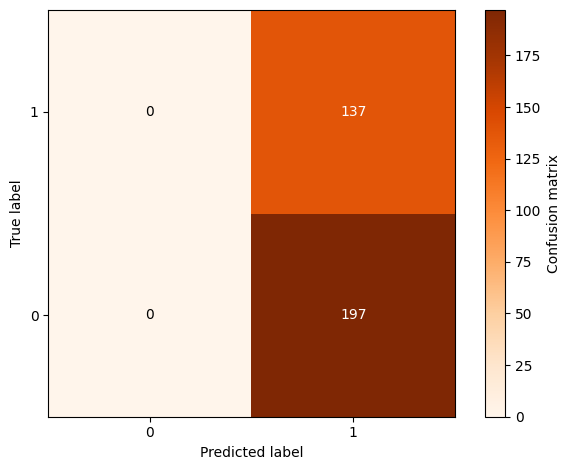

In [ ]:
plotting.plot_confusion_matrix(y_test, y_pred_labels, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

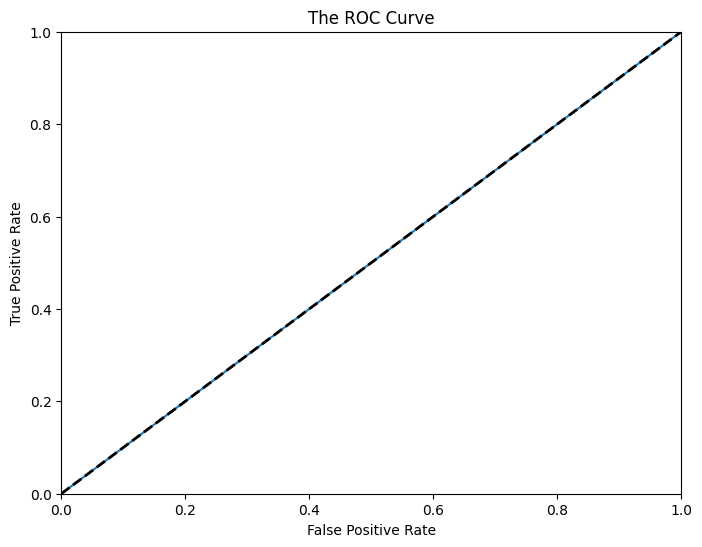

In [ ]:
# Save ROC curves to plot them all together later
model_iv_roc_curves = []

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

# Save curves to list
model_iv_roc_curves.append((fpr, tpr, auc))

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model IV'] = model_iv_roc_curves

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.4101796407185629
Precision: 0.16824733766000932
F1_score: 0.2386183047916905
Accuracy: 0.4101796407185629
TSS: 0.0
AUC: 0.5


# Model V: VGG16 Convolutional Neural Network (CNN) with Vision Transformer (ViT) and original images

This model uses the original images as inputs to a CNN with a Vision Transformer (ViT) to classify the galaxies. ViT is used as a data augmentation tool on the Galaxy and Non-Galaxy images. The Zernike Moments (ZMs) are not used here.

## Loading the data (images)
To read the images of each class and convert to Pillow images we used the following function (Ghaderi et al., 2024):

## Splitting into train and test sets

We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
np.random.seed(42)

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=2)

## Applying the Vision Transformer (ViT)

We apply the vision transformer to both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

The galaxy and non-galaxy classifiers are unbalanced class models. This means that one class significantly outweighs the other. Therefore, we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

## Training

The structure of the classic CNN model:

In [ ]:
def build_model():
  # Defining the pretrained VGG16
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

  x = Flatten()(base_model.output)
  x = Dense(64, activation='relu')(x)  # The custom layers
  output = Dense(2, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)

  return model

VGG16 uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Getting the initial weights of the model
# in case we need to reset it later - Issa
initial_weights = model.get_weights()

In [ ]:
# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6293 - loss: 4.4124 - val_accuracy: 0.6337 - val_loss: 2.4417
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.6679 - loss: 0.9075 - val_accuracy: 0.5644 - val_loss: 3.6093
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.7674 - loss: 0.6024 - val_accuracy: 0.4158 - val_loss: 3.2164
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.7281 - loss: 0.5783 - val_accuracy: 0.4653 - val_loss: 2.3782
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 379ms/step - accuracy: 0.7817 - loss: 0.5020 - val_accuracy: 0.6238 - val_loss: 1.4964
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.7768 - loss: 0.5917 - val_accuracy: 0.4257 - val_loss: 1.7060
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.7052 - loss: 0.7150 - val_accuracy: 0.6733 - val_loss: 0.7056
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.8467 - loss: 0.4637 - val_accuracy

## Performance

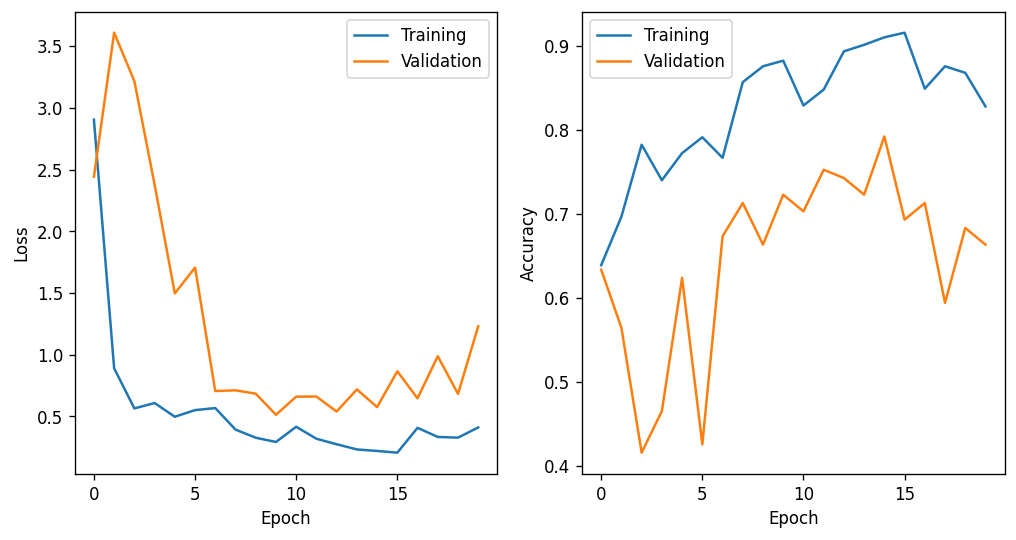

In [ ]:
plotting.plot_model_history(history, dpi=120)

Now, we apply the model to the test set to examine the classification algorithm. Using the label predicted by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
# Confusion matrix
X_test = np.array(transformed_X_test)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

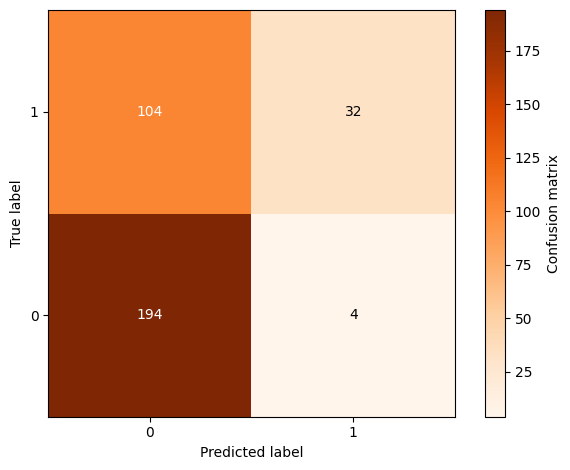

In [ ]:
plotting.plot_confusion_matrix(y_test, y_pred_labels, cmap=plt.cm.Oranges)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates for the classifier.

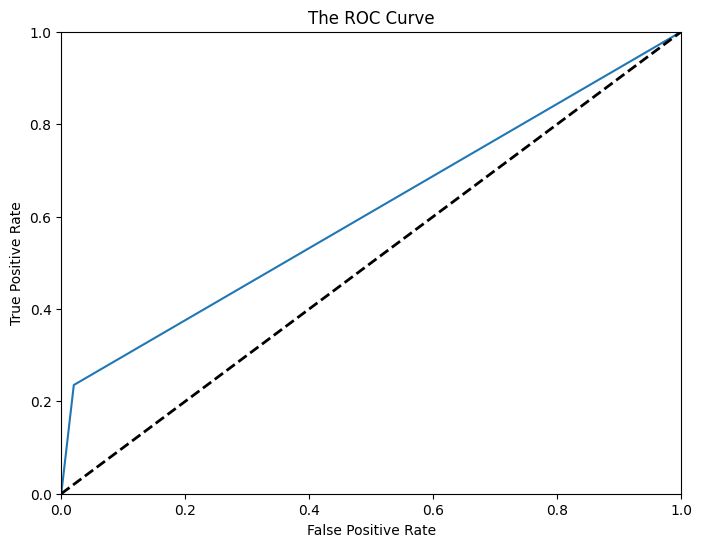

In [ ]:
# Save ROC curves to plot them all together later
model_v_roc_curves = []

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

# Save curves to list
model_v_roc_curves.append((fpr, tpr, auc))

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model V'] = model_v_roc_curves

To measure the performance metrics of the classifier, we compute **Recall, Precision, f1_score, Accuracy, and TSS(True Skill Statistic)**.

In [ ]:
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.6766467065868264
Precision: 0.7478689154130218
F1_score: 0.615244754302348
Accuracy: 0.6766467065868264
TSS: 0.21509209744503863
AUC: 0.6075460487225194


## **Model Comparisons**

In [ ]:
# ROC Curves for Spiral Galaxy
plt.figure(figsize=(16, 6), dpi=100)

# Iterate over models
for model_name in roc_curves:

  # Get the ROC curve data of the current model
  fpr = roc_curves[model_name][0]
  tpr = roc_curves[model_name][1]
  auc = roc_curves[model_name][2]

  # Plot curve for current model
  plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', lw=1)

  # Plot random guess curve
  plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

title(f'{class_name}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
#plt.savefig('clean_final_1')
plt.show()